# <span style="color:SlateBlue">1. Imports, type in the protein to be displayed</span>

### Not every protein can be equilibrated directly after downloading from the Protein Database. Often, the code cannot run correctly due to missing hydrogen atoms or residues. In this tutorial, .pdb fixer created by a previous lab group can configure our files to run correctly.

In [2]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
from time import time

#type in the name of the protein you're working with inside the quotation marks(e.g. 1yiy, 3hfb)
#note: 1nmf is already in this directory, but you will have to add 1a57.
the_protein = "5z5w"

#sends printout to separate log file
log = open(the_protein + ".log", "a")
sys.stdout = log

### An attempt to run 5z5w should cause an error (i.e. an exception). This exception should be displayed after running block 2. You can note what parts of the structure were missing in the .log file. 

# <span style="color:SlateBlue">2. Load a structure and set up the simulation parameters and data structures</span>

In [3]:
protein = PDBFile(the_protein + '.pdb')
forcefield = ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3p.xml')
# Create Modeller object  This Modeller object will be used in place of the
# actual pdb file.
protein_model = Modeller(protein.topology, protein.positions)

# Add a tip3p waterbox solvent
protein_model.addSolvent(forcefield, model = 'tip3p', padding = 1.5*nanometers)

try:
    protein_model.addSolvent(forcefield, model = 'tip3p', padding = 1.5*nanometers)
except Exception as e:
    print(e)
    display("Exception logged. Run pdb fixer before proceeding.")

In [7]:
# Create and setup the system/environment as well as the integrator
# to be used in the simulation. Values will be recorded at every femtosecond
# (1 femtosecond = 1 timestep), and the system will be set to stay at around
# 296 Kelvin

system = forcefield.createSystem(protein_model.topology, nonbondedMethod = PME, 
                                 nonbondedCutoff = 1.0*nanometers, constraints = HBonds)
integrator = LangevinIntegrator(296*kelvin, 1.0/picosecond, 1.0*femtosecond)

# Specify the platform/processor that will be used to run the simulation on.
# Since the average person will be doing these simulations on their own computer
# with no special modifications, 'CPU' will be the only platform one wll be able
# to use.
platform = Platform.getPlatformByName('CPU')

# Initialize the simulation with the required topology, system, integrator, and
# platform, as well as set the positions of the molecules in the simulation.
simulation = Simulation(protein_model.topology, system, integrator, platform)
simulation.context.setPositions(protein_model.positions)

### The .pdb fixer will detail the changes made in the .log file. After you finish running the code block, you should be able to run Block 2 again (without an exception), and skip to Block 4. 

# <span style="color:SlateBlue"> 3. PDB fixer excerpt that gets rogue PDB files working </span>

pdbfixer fixes issues with missing residues, missing H atoms, and adds in solvent


In [13]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile
protein_file = the_protein + '.pdb'
fixer = PDBFixer(filename= protein_file)
numChains = len(list(fixer.topology.chains()))  #these two lines remove all chains but the first
fixer.removeChains(range(1, numChains)) #these two lines remove all chains but the first
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(False)  #the "false" also removes waters
fixer.findMissingAtoms()
fixer.addMissingAtoms()
#changed to 9.0
fixer.addMissingHydrogens(7.0)
# fixer.addSolvent(fixer.topology.getUnitCellDimensions(), positiveIon='Na+', negativeIon='Cl-', ionicStrength=0.0*molar)
PDBFile.writeFile(fixer.topology, fixer.positions, open(protein_file, 'w'))
print('Done writing fixed PDB')
print('Done adding solvent')

# <span style="color:SlateBlue"> 4. Minimization: provides an initial low energy structure </span>

In [8]:

# Get the initial state of the system and print out the values for
# potential and kinetic energy
st = simulation.context.getState(getPositions=True, getEnergy=True, enforcePeriodicBox=True)
print("Potential energy before minimization is %s" % st.getPotentialEnergy())
print("Kinetic energy before minimization is %s" % st.getKineticEnergy())

# Minimize the simulation for at most 100 iterations (the simulation 
# can potentially stop minimizing if the kinetic energy has been sufficiently
# minimized before it reaches 100 iterations, although you won't be able
# to tell), while also taking note of how long it takes for the minimization to
# finish.
print('Minimizing...')
tinit = time()
simulation.minimizeEnergy(maxIterations=100)
tfinal = time()

# Get the new state of the system and print out the values for
# potential and kinetic energy.
st = simulation.context.getState(getPositions=True,getEnergy=True, enforcePeriodicBox=True)
print("Potential energy after minimization is %s" % st.getPotentialEnergy())
print("Kinetic energy after minimization is %s" % st.getKineticEnergy())

# Print out the length of time the minimization took to complete.
print("Done Minimization! Time required: ", tfinal-tinit, "seconds")



### It's a good sign if you have been able to run the program so far, but it may be a good habit to check the "fixed" protein in a protein viewer such as VMD prior to running more calculations on it. Some of the proteins in previous experiments, branched out into long chains (which is not very equilibrated, see below:)

![A quirky pdb fixer result...](https://github.com/sebashhh/wwk-repository/blob/main/Potential_Protein_Error_Pic.png)

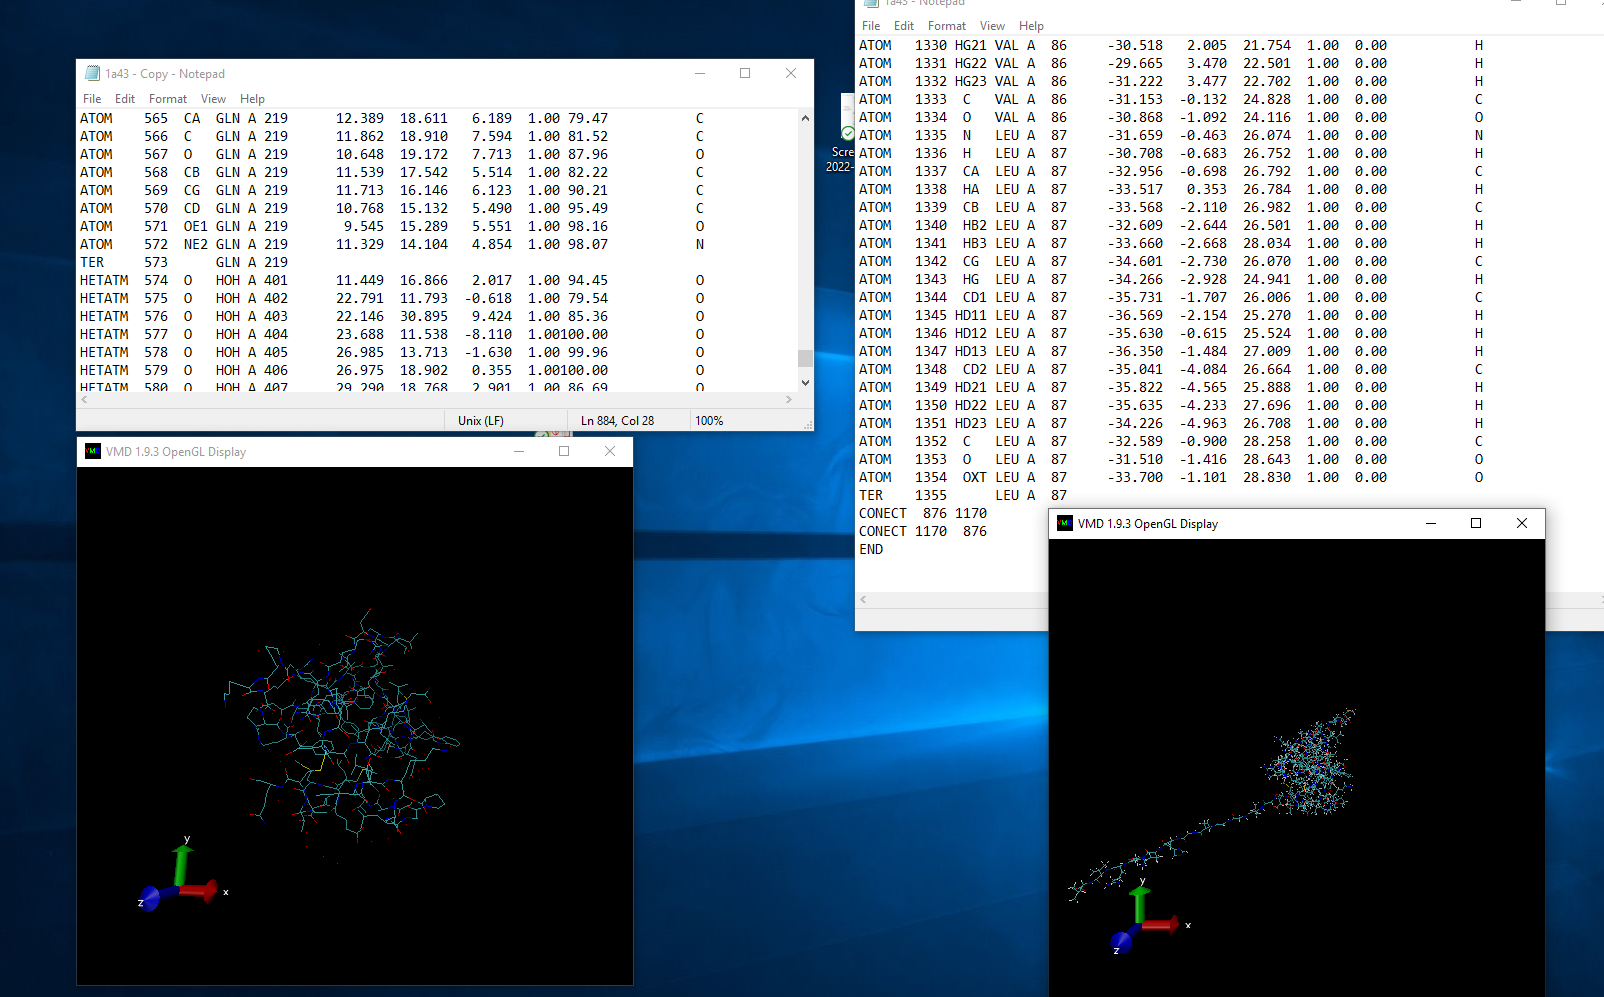

### At this point you should be able to run the subsequent cells, but be sure to keep track of error messages/exceptions, and let your instructor know it they can't be resolved with a little tinkering!


# <span style="color:SlateBlue"> 5. Equilibration: sets initial velocities and brings system up to desired temperature </span>

In [ ]:
# Set the system to maintain atom velocities such that the temperature of
# the system fluctuates around 296 Kelvin throughout the rest of the 
# equilibration and final simulation.
simulation.context.setVelocitiesToTemperature(296*kelvin)

# Equilibrate the system for 10,000 timesteps while also taking note of 
# how long it takes for the equilibration to finish.
print('Equilibrating...')
tinit = time()
simulation.step(10000)   #number is how many timesteps of equilibration to do
tfinal = time()

# Print out the length of time the equilibration took to complete.
print("Done equilibrating! Time required:", tfinal - tinit, "seconds")


# <span style="color:SlateBlue"> 6. Production: creates trajectory at desired temperature, starting from end of equilibration

In [ ]:
# Set up simulation to save important values needed for visualization purposes
# to a PDB file and a DCD file, as well as report the timestep, the kinetic
# and potential energies, and the temperature of the system to the standard
# output, every 100 timesteps.
Nsteps=10000
print_every_Nsteps=100
simulation.reporters.append(PDBReporter(the_protein + '_trajectory.pdb', print_every_Nsteps))
simulation.reporters.append(StateDataReporter(stdout, print_every_Nsteps, step=True, kineticEnergy=True, 
    potentialEnergy=True, temperature=True, separator='\t'))

# Start the simulation, while also taking note of how long it takes for the
# simulation to finish. When the values are shown in the standard output,
# it will look like the simulation starts at at the 10,000th timestep. That's
# because we are looking at the current state of the system. We already told
# the simulation to go through 10,000 timesteps in the equilibration step, so
# that's what's being reflected here.
tinit = time()
print('Running Production on ' + the_protein + '...')
simulation.step(Nsteps)
tfinal = time()
print('Done!')

# Print out the length of time the simulation took to complete.
print('Done production! Time required:', tfinal-tinit, 'seconds')
print("Number of steps:", Nsteps)


# <span style="color:SlateBlue"> 7. Trajectory analysis using the mdtraj package

In [ ]:
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np

In [ ]:
traj = md.load(the_protein + '_trajectory.pdb')
print(traj)

### After running every line of code, you should have trajectory files and a pdb file comparable to the first example. It can be a helpful exercise to download a protein like 5z5w again, renaming it, and comparing the counts of atoms & residues to the "fixed file."

In [ ]:
print('How many atoms?    %s' % traj.n_atoms)   #prints out number of atoms in simulation
print('How many residues? %s' % traj.n_residues)   #prints out number of residues in simulation
print('How many water molecules? %s' % traj.atoms_by_name(self, water))
print('Second residue: %s' % traj.topology.residue(1))   #prints out the residue label for the number you put in
atom = traj.topology.atom(2)      #picks out a specific atom (based on the number) for further interrogation
print('''Hi! I am the %sth atom, and my name is %s. 
I am a %s atom with %s bonds. 
I am part of an %s residue.''' % ( atom.index, atom.name, atom.element.name, atom.n_bonds, atom.residue.name))


### After running every line of code, you should have trajectory files and a pdb file comparable to the first example. It can be a helpful exercise to download a protein like 5z5w again, renaming it, and comparing the counts of atoms & residues to the "fixed file."